# Python Implementation of a Lattice Gas Monte Carlo Simulation

> A simple python implementation of a lattice gas Monte Carlo simulation
- toc: True
- metadata_key1: Python
- metadata_key2: Monte-Carlo
- metadata_key3: lattice gas

This notebook contains a simple python implementation of a Monte Carlo simulation of a [lattice gas](https://www.amazon.com/Introduction-Modern-Statistical-Mechanics-Chandler/dp/0195042778) (and [here](https://onlinelibrary.wiley.com/doi/pdf/10.1002/9783527676750.app3)), which is strongly related (i.e. [isomorphic](https://en.wikipedia.org/wiki/Isomorphism)) to the [Ising model](https://en.wikipedia.org/wiki/Ising_model), a simple  statistical mechanics model to describe ferromagnetism.

The lattice gas model is one of the simplest models that can describe phase transitions, such as ordered to unordered states. The volume available for a molecule is divided in cells on a regular grid. Here only the 2-dimensional case is shown with a coordination number of z=4. In three dimensions one can have a simple cubic (SC) lattice with z = 6, a body-centered cubic (BCC) lattice with z = 8, or a face- centered cubic(FCC) lattice with z = 12.

Attractive interaction only take place between nearest neighbor cells. The lattice model (Ising model) can be solved completely (i.e. no simulation or mean field approximation necessary) for the 2D dimensional case without an applied field . For all other cases only approximate solutions exist or numerical simulations have to be carried out.

This notebook is loosely based on the book "Introduction to Modern Statistical Mechanics" by David Chandler and on this freely available [book chapter](https://onlinelibrary.wiley.com/doi/pdf/10.1002/9783527676750.app3).

To speed up the computations costly operations are wrapped with a [Numba](https://numba.pydata.org/) decorator, which carries out a just-in-time (JIT) compilation of the underlying code. Hence, the code runs as nearly as fast as native C code!  



Here we load the basic libraries. [Numpy](https://numpy.org/) for linear algebra, [matplotlib](https://matplotlib.org/) for plotting and some utilities (e.g. tqdm shows a handy progress bar in loops)

In [266]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import time
from tqdm.auto import tqdm, trange
from numba import jit

The random seed is defined for reproducibility and some parameters are defined as the  size of the (quadratic) grid, the chemical potential $\mu$ (~ magnetic moment in the Ising model) and the interaction energy $\epsilon$ and $\beta = (RT)^{-1}$. For now with some arbitrary values.

The energy of a state is computed by:

$E = \mu\sum_{i}\sigma_{i} + \sum_{i \neq j}\sigma_{ij}\epsilon\beta$

where the indices i,j run over the lattice sites. $\sigma_{i}$ is 1 if the corresponding lattice site is occupied otherwise its zero, similarly $\sigma_{ij}$ runs only over next neighbour interactions.

In [591]:
np.random.seed(123)
cmap = plt.cm.gray_r # reversed colour map: black 1 white 0
nsize=20
mu = 0.0 # ~ simple chemical potential - keep it zero in order to keep number of particles constant
epsilon = -2.0 # interaction energy
T = 500 # temperature
MAX_ITER = 1000 # max ierations
beta = (0.02 * T)**-1 

(0.1, -0.2)

Later on we will play with those parameters, i.e. choose a positive or negative chemical potential, increase interaction energy or temperature and see what changes and characteristics are introduced within the model.

### Define some utility functions here

We are using the [numba](http://numba.pydata.org/) library in order to increase computation speed of python code.  
In order to do this one places the '@jit' decorator in front of a function.


In [592]:
@jit(nopython=True)
def flip_state(a):
    pos = np.random.randint(nsize*nsize)
    tmp = a.flatten()
    tmp[pos] = !tmp[pos]
    a = tmp.reshape((nsize,nsize))
    return a


@jit(nopython=True)
def flip_states(a,n=10):
    tmp = a.flatten()
    #poslist = np.random.randint(nsize*nsize,size=n)
    poslist = [np.random.randint(nsize*nsize) for x in range(n) ]
    for pos in poslist:
        tmp[pos] = not tmp[pos]
    a = tmp.reshape((nsize,nsize))
    return a


@jit(nopython=True)
def move_state(a):
    tmp = a.copy()
    #select random position
    i = np.random.randint(nsize)
    j = np.random.randint(nsize)
    #select random move
    move = np.random.randint(4) # 0: top 1: left 2: down 3: right
    new_idx = get_neighbour_indices(i,j)[move]
    tmp[i,j],tmp[new_idx] = tmp[new_idx],tmp[i,j]
    return tmp


@jit(nopython=True)
def move_states(a,n=10):
    tmp = a.copy()
    #ilist = np.random.randint(nsize,size=n) # not supported by numba
    ilist = [np.random.randint(nsize) for x in range(n) ]
    jlist = [ np.random.randint(nsize) for x in range(n)]
    for i,j in zip(ilist,jlist):
        move = np.random.randint(4) # 0: top 1: left 2: down 3: right
        new_idx = get_neighbour_indices(i,j)[move]
        #print(new_idx,move)
        tmp[i,j],tmp[new_idx] = tmp[new_idx],tmp[i,j]
        #print(tmp[i,j])
    return tmp

In [593]:
@jit(nopython=True)
def pbc1(x):
    if x>=0:
        return x
    else:
        return x+nsize
    
@jit(nopython=True)
def pbc2(x):
    if x<nsize:
        return x
    else:
        return x-nsize

@jit(nopython=True)
def get_neighbour_indices(i,j):
    #peridoic boundary conditions
    top = (pbc1(i-1),j)
    left = (i,pbc1(j-1))
    down = (pbc2(i+1),j)
    right = (i,pbc2(j+1))
    nidxs = [top,left,down,right]
    return nidxs

@jit(nopython=True)
def compute_energy(state, verbose = False):
    """
    Here we compute the energy of the full system, it would be more
    effcient to compute only the local energy change(s)...
    """
    e = 0.0
    eint = 0.0
    for i in range(nsize):
        for j in range(nsize):
            e += mu * state[i,j]
            #print(i,j)
            nidxs = get_neighbour_indices(i,j)
            et = 0.0
            for ni in nidxs:
                et += 0.5 *epsilon * state[i,j] * state[ni]
            #print(nidxs)
            eint += et
    #if verbose: 
    #    print(f"mu={e:.1f} E_int={eint:.1f} beta={beta:.2f}")
    return beta*(e+eint)

### Building the model

First we initalize a complete ordered state and plot it.

<IPython.core.display.Javascript object>


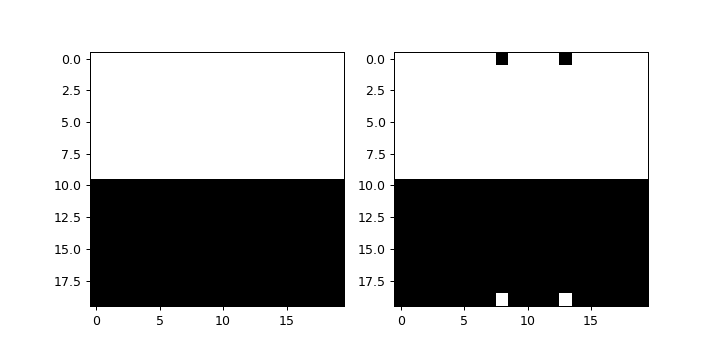

In [594]:
# initialize a ordered state
state_init = np.ones((nsize,nsize),dtype=bool)
state_init[:int(nsize/2),:] = 0

# ... side by side
fig=plt.figure(figsize=(8, 4))
fig.add_subplot(1, 2, 1)   # subplot one
plt.imshow(state_init, cmap=cmap)
fig.add_subplot(1, 2, 2)   # subplot two
# my data is OK to use gray colormap (0:black, 1:white)
s2 = move_states(state_init)
plt.imshow(s2, cmap=cmap)  # use appropriate colormap here

This gives some lowest energy boundary, similar to an ordered crystalline state. Unlike a real surface particle can just be
turned off and on, i.e. basically moving without boundaries or hinderance of the other particles.

Here we compute the energy of the completely ordered low energy state and of one with some arbitrarily flipped positions for reference.

In [595]:
compute_energy(state_init, verbose = True)

-76.0

In [597]:
 compute_energy(s2,verbose = True)

-74.8

### Initialize a random state

Now lets initialize some random state and note the difference (much higher energy i.e. less interactions made between particles).

<IPython.core.display.Javascript object>


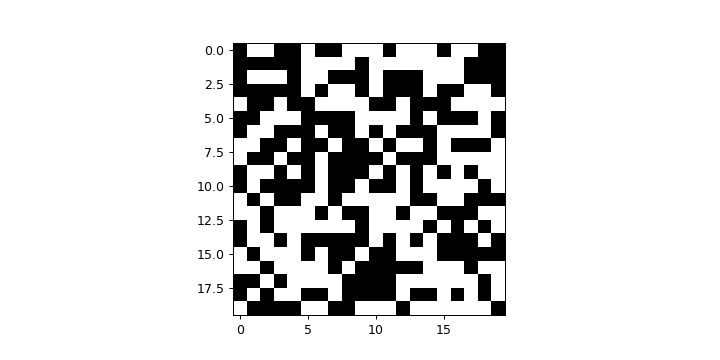

In [598]:
fig=plt.figure(figsize=(8, 4))
# initialize a random state
state_init = np.random.rand(nsize,nsize)>0.5 
plt.imshow(state_init, cmap=cmap)

Correspondingly the energy is now much higher than for the completely ordered state (we have no entropy term introduced, which might  stabilize these messy states at higher temperatures).

In [599]:
print(state_init.sum())
compute_energy(state_init, True)

199


-38.800000000000004

Here we just prepare some (interactive) plotting.

In [600]:
#%matplotlib notebook
def pltsin(ax,ax2,at, a, e_list,e_min_list):
    e = e_list[-1]
    e_min = e_min_list[-1]
    ax.imshow(a, cmap=cmap)
   
    at.set_text("energy = {:6.2f}\ne_min = {:6.2f}".format(e,e_min))
    ax2.plot(e_list,c='black')
    ax2.plot(e_min_list,c='red')
    fig.canvas.draw()

This is the Monte-Carlo simulation loop.

In [601]:
@jit(nopython=True)
def run_simulation(state,MAX_ITER=10000, verbose = False):
    e_min = compute_energy(state)
    state_min = state
    e_new,e = e_min, e_min
    e_list = [e_min]
    e_min_list = [e_min]
    
    for i in range(MAX_ITER):
        new_state = move_states(state,n=10)
        e_new = compute_energy(new_state)
        # accept if new energy is lower
        if e_new<e:
            e = e_new
            state = new_state
        # if new energy is higher use monte-carlo criterion
        else:
            t = np.random.rand()
            e_delta = e_new-e_min
            f = -e_delta
            acc_str = '-'
            if np.exp(f)>=t:
                state = new_state
                e = e_new
                acc_str = '+'
            else:
                pass # reject step
        
        if e<e_min:
            e_min = e
            state_min = state

        e_list.append(e)
        e_min_list.append(e_min)
        #if verbose: pltsin(ax,ax2,at,state,e_list,e_min_list)
            
    #fig, (ax,ax2) = plt.subplots(1,2)
    #at = ax2.text(0,-4,"",color='red')
    #ax.imshow(state_min, cmap=plt.cm.gray)
    #ax2.plot(e_min_list)
    #ax2.plot(e_list)
    return state_min,e_min_list,e_list

### Run the simulation

You can iterate through these cells in order to continue the simulation with more steps.

In [608]:
%%time
state = state_init
MAX_ITER = 100000
state_min,e_min_list,e_list = run_simulation(state_init,MAX_ITER)
state_init = state_min
#state_min,e_min_list,e_list

Wall time: 18.2 s


<IPython.core.display.Javascript object>


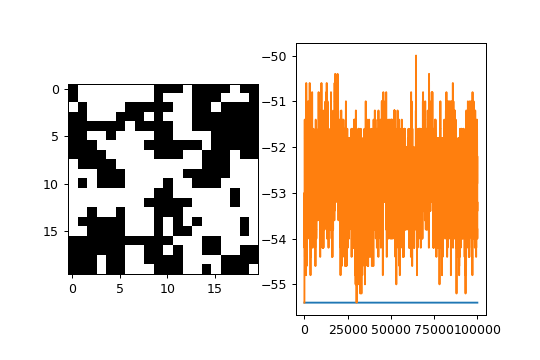

In [609]:
fig, (ax,ax2) = plt.subplots(1,2)
at = ax2.text(0,-4,"",color='red')
ax.imshow(state_min, cmap=cmap)
ax2.plot(e_min_list)
ax2.plot(e_list)

In [610]:
print(state_min.sum())
compute_energy(state_min)

199


-55.400000000000006

You should see some larger droples/aggregates being formed. You may play around i.e. increasing the temperature in order disturb this phase transition.   
At some point no droplets can be formed anymore, the corresponding temperature is called the 'critical' temperature.